<a href="https://colab.research.google.com/github/cheveanrichards/VAE_Pytorch/blob/main/Generating_Anime_Faces_VAE_with_Pytorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'another-anime-face-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F923624%2F2154267%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T200548Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D002d2a5b53a75b5fde9ffce1fdc8ac23a24835431465440d55bc957249326b27f2e607654520b792b66e7d4356fc18ee2424ff7ae137a90beb5420b55ece9484b5b0a76dfc6f835680e3f8d24dee67cb8bf66938fdd13865a0512addd568075ea2f585f0cd52e8ef123d4d3ebdb0533efc6c93b905d1d50d5bd96e7f12fa722cdf595be686f6b24a2a1efb2a2885f86332cef0f1780241e57301acec0728dc2fb019ddf906ddb874147eb4f2d50535cf391ac0da91dba5a04c18ddb7e68b698fd9cc69b876489c8137c350911e9205d2860cae3fa3704dff65f0c0a90b6a66ff8edb7d5b4b3a040322d64ae7b893aa36f384fa5c34775fa1343af7a855152c4b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1545320711 bytes downloaded
Downloaded and uncompressed: another-anime-face-dataset
Data source import complete.


In [3]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 16.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [4]:
import torch
import lightning as PL
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
import os
from torchmetrics import Accuracy, F1Score

In [5]:
def load_images(folder_path, img_size = 64):
    X = []
    transform = transforms.Resize((img_size, img_size))
    for img_name in tqdm(os.listdir(folder_path)):
        try:
            img_path = os.path.join(folder_path, img_name)
            img_tensor = torchvision.io.read_image(img_path)
            img_tensor = transform(img_tensor)
            X.append(img_tensor / 255.0)
            if len(X) > 100000:
                break
        except:
            pass
    return X
dataset = load_images(r'/kaggle/input/another-anime-face-dataset/animefaces256cleaner')
dataset[0].shape

100%|██████████| 92219/92219 [01:50<00:00, 835.06it/s]


torch.Size([3, 64, 64])

In [6]:
train_loader = torch.utils.data.DataLoader(dataset, shuffle = True, batch_size = 64, num_workers = 3)
a = next(iter(train_loader))
a.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 3, 64, 64])

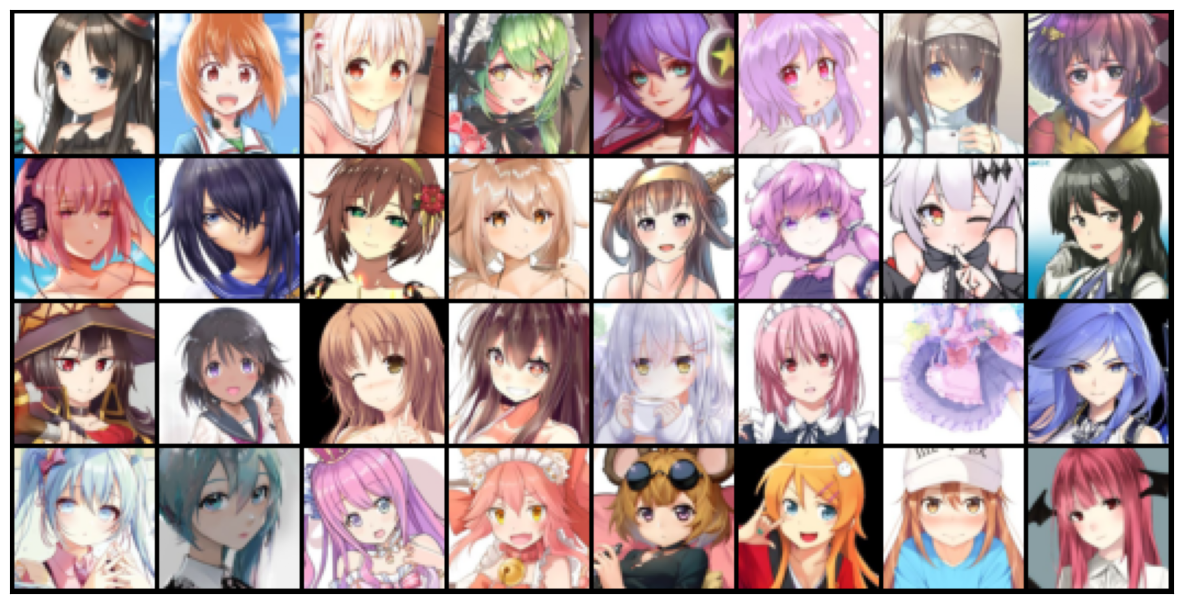

In [7]:
def show_images(images, N = 32):
    plt.figure(figsize = (15, 15))
    grid = torchvision.utils.make_grid(images[:N])
    grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()
show_images(a)

In [8]:
class VariationalAutoencoder(PL.LightningModule):
    def __init__(self, latent_dim = 64):
        super().__init__()
        self.latent_dim = latent_dim
        self.KL_coef = 0.5
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(4*4*512, 512),
            nn.LeakyReLU()
        )

        self.get_mean = nn.Linear(512, self.latent_dim)
        self.get_logvar = nn.Linear(512, self.latent_dim)

        self.decoder_linear = nn.Sequential(
            nn.Linear(self.latent_dim, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 4*4*512),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(self.decoder_linear(x).reshape(-1, 512, 4, 4))

    def sample(self, mean, logvar):
        epsilon = torch.randn_like(mean)
        return mean + torch.exp(0.5 * logvar) * epsilon

    def forward(self, x):
        out = self.encode(x)
        mean, logvar = self.get_mean(out), self.get_logvar(out)
        z = self.sample(mean, logvar)
        out = self.decode(z)
        return out, mean, logvar

    def vae_loss(self, fake_images, real_images, z_mean, z_log_var):
        reconstruction_loss = torch.mean(torch.square(real_images))
        kl_loss = -self.KL_coef * torch.mean(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var))
        total_loss = reconstruction_loss + kl_loss
        return kl_loss, reconstruction_loss, total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.0003)

    def training_step(self, batch, batch_idx):
        x = batch
        x_recon, mu, log_var = self(x)
        recon_loss = F.binary_cross_entropy(x_recon.view(x.size(0), -1), x.view(x.size(0), -1), reduction='sum')
        kl_divergence = -self.KL_coef * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_divergence
        self.log_dict({'KL_Loss' : kl_divergence, 'reconstruction_loss' : recon_loss, 'total_loss':loss}, prog_bar = True, on_epoch = True)
        return loss

In [12]:
model = VariationalAutoencoder()
trainer = PL.Trainer(accelerator = 'gpu', max_epochs = 10)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, train_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 5.7 M 
1 | get_mean       | Linear     | 32.8 K
2 | get_logvar     | Linear     | 32.8 K
3 | decoder_linear | Sequential | 4.2 M 
4 | decoder        | Sequential | 1.6 M 
----------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.389    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 5.7 M 
1 | get_mean       | Linear     | 32.8 K
2 | get_logvar     | Linear     | 32.8 K
3 | decoder_linear | Sequential | 4.2 M 
4 | decoder        | Sequential | 1.6 M 
----------------------------------------------
11.6

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


torch.Size([64, 3, 64, 64])


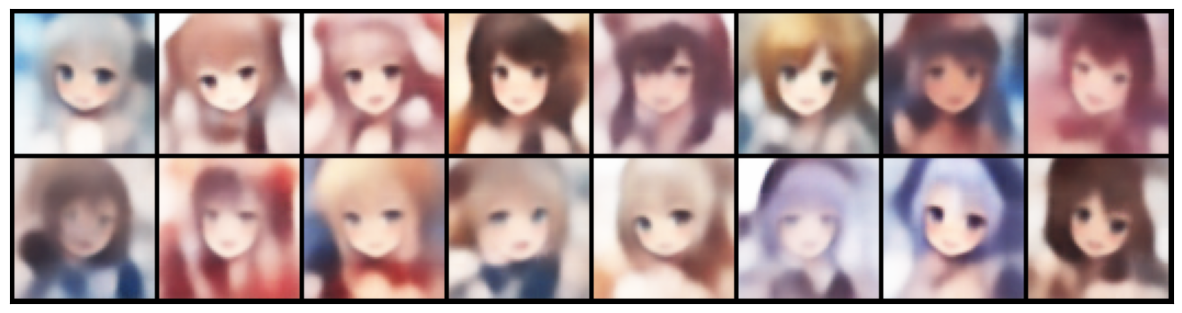

In [14]:
z = torch.randn(64, 64)
y_pred = model.decode(z)
print(y_pred.shape)
show_images(y_pred, 16)